# Comparing the impact of various criteria on the brain path algorithm efficiency.

In [1]:
import torch
from utils import device # detects whether you are using CPU or GPU
import matplotlib.pyplot as plt
from cust_plot import plot_rewards, plot_success, plot_mu, plot_sig
import numpy as np
import glob, os
import re

In [2]:
import pandas as pd

In our experiments we compute the pathway by navigating to a node according to a weighted combination of criteria, defined below.

In [3]:
criteria = ['streamlines','node_str','target_node','target_region','hub','neighbour_just_visited_node','edge_con_diff_region','inter_regional_connections','prev_visited_region','target_func_region','edge_con_diff_func_region','prev_visited_func_region']

## Main functions

This section is defining some functions to run the experiments. Namely, for a given brain and a given set of criteria, we read the results of an experiment. We then collate these results by brain, by batch, and by sets of criteria.

In [4]:
def process_brainexperiment(brain,exp, batch, n_av=1000):
    """
    Read the results for a single experiment.

    Return a list of four values: the mean reward, the mean success rate, the mean μ and the mean σ.
    """
    file = f"../R{exp:02}_sl_ns_{brain}_{batch}.pt"
    if os.path.isfile(file):
        tr_data = torch.load(file, map_location=device)
        reward_list = tr_data['rewards']
        success_list = tr_data['success']
        mu_list = tr_data['mu']
        mu_scale = abs(np.array(mu_list)).sum(axis=0)
        mu_list = mu_list / mu_scale
        sigma_list = tr_data['sig']
        sigma_list = sigma_list / mu_scale
        
        reward_mean = np.mean(reward_list[-n_av:])
        success_mean = np.mean(success_list[-n_av:])
        mu_mean = np.mean(mu_list[:][-n_av:],axis=1)
        sigma_mean = np.mean(sigma_list[:][-n_av:],axis=1) 
        return [reward_mean,success_mean,mu_mean,sigma_mean]
    else:
        return [np.NaN,np.NaN,[],[]]

In [5]:
def process_brain(brain,batch,n_av = 1000):
    """
    Compile all the experiments for a given brain and a given batch. These experiments consist of removing one criterion at a time and compute the weights maximising the average efficiencies of the paths.
    """
    results = [process_brainexperiment(brain, exp, batch, n_av) for exp in range(1,14)]
    return results

In [6]:
def get_brain_efficiencies(brain, batch, n_av = 1000):
    """
    Compute the efficiencies for a given brain, for each set of criteria.
    """
    results = process_brain(brain,batch, n_av)
    efficiencies = np.array([r[0] for r in results])
    scaledefficiencies = 1 - efficiencies/efficiencies[0]
    return {criteria[i]: v  for (i,v) in enumerate(scaledefficiencies[1:])}

In [7]:
def process_batch(batch):
    """
    Compile a dict containing the efficiency results for each brain in a batch of experiments.
    """
    flist = glob.glob(f"../R*{batch}.pt")
    brainlist = np.unique(np.sort([int(re.findall(r'\d+',file)[1]) for file in flist]))
    efficiencies = {}
    for brain in brainlist:
        efficiencies[brain] = get_brain_efficiencies(brain,batch)
    return efficiencies

In [8]:
def compare_brain_by_batch(brain):
    flist = glob.glob(f"../R*_{brain}_*.pt")
    batchlist = np.unique(np.sort([int(re.findall(r'\d+',file)[2]) for file in flist]))
    efficiencies = {}
    for batch in batchlist:
        efficiencies[batch] = get_brain_efficiencies(brain,batch)
    return efficiencies

In [9]:
def compare_everything():
    """
    Compile the results of all the experiments we have. This function returns a dict of dicts of dicts. 
    At the higher level are the batches, then middle level the brains and finally the criteria.
    """
    flist = glob.glob(f"../R*_*.pt")
    batchlist = np.unique(np.sort([int(re.findall(r'\d+',file)[2]) for file in flist]))
    print(batchlist)
    efficiencies = {}
    for batch in batchlist:
        print(batch)
        efficiencies[batch] = process_batch(batch)
    return efficiencies

In [10]:
def compile_data():
    """
    Compile a pandas dataframe containing the results of all the experiments.
    """
    results = compare_everything()
    res = {k:pd.DataFrame(results[k]) for k in results}
    for k in res:
        head = pd.MultiIndex.from_arrays([[k]*res[k].shape[1],res[k].columns])
        res[k].columns = head
    df = pd.concat([res[k] for k in res],axis=1)
    return df

In [11]:
def update_data(recompute=False):
    """
    Update the data and the excel spreadsheet.
    """
    if recompute:
        df = compile_data()
        df.to_excel("results.xlsx")
        batchlist = df.columns.get_level_values(0).unique().values
        with pd.ExcelWriter('results_by_batch.xlsx') as writer:
            for batch in batchlist:
                df.loc(axis=1)[batch,:].to_excel(writer,sheet_name=f"{batch}")
    else:
        df = pd.read_excel("results.xlsx",header=[0,1],index_col=[0])
    return df

## Analysis

In this section we perform an analysis of the data.

The main structure is a pandas dataframe `df` computed using the function `compute_data` (see previous section). By default this function reads the results from an excel spreadsheet ("results.xlsx"), though it can be made to recompute all the data by calling `df = compute_data(recompute=True)`. Recomputing the dataframe takes time and is only necessary if new data has been created.

The dataframe `df` contains the criteria efficiency for each experiment (each brain, batch and criteria). There are two column headers: the batches and the brain, and one row index: the criteria. It is therefore possible to access the efficiency for each individual criterion, and is also possible to compile results per individual brain, individual batch and/or individual criterion.

For example:
``` {python}
> # access all the data for Brain 3:
> df.loc(axis=1)[:,3]

> # access all the data for Batch 98:
> df.loc(axis=1)[98,:]


> # access all the data for streamlines:
> df.loc(axis=0)["streamlines"]

> # access the efficiency for the `streamlines` criterion for brain 3 in batch 95:
> df.loc["streamlines"][95,3]
```

The efficiencies are computed using the following formula:

$$\mathrm{eff}(c) = 1-r_c/r,$$
where $r$ is the reward achieved using all the criteria, and $r_c$ the reward achieved using all criteria except criterion $c$.

In [12]:
df = update_data()

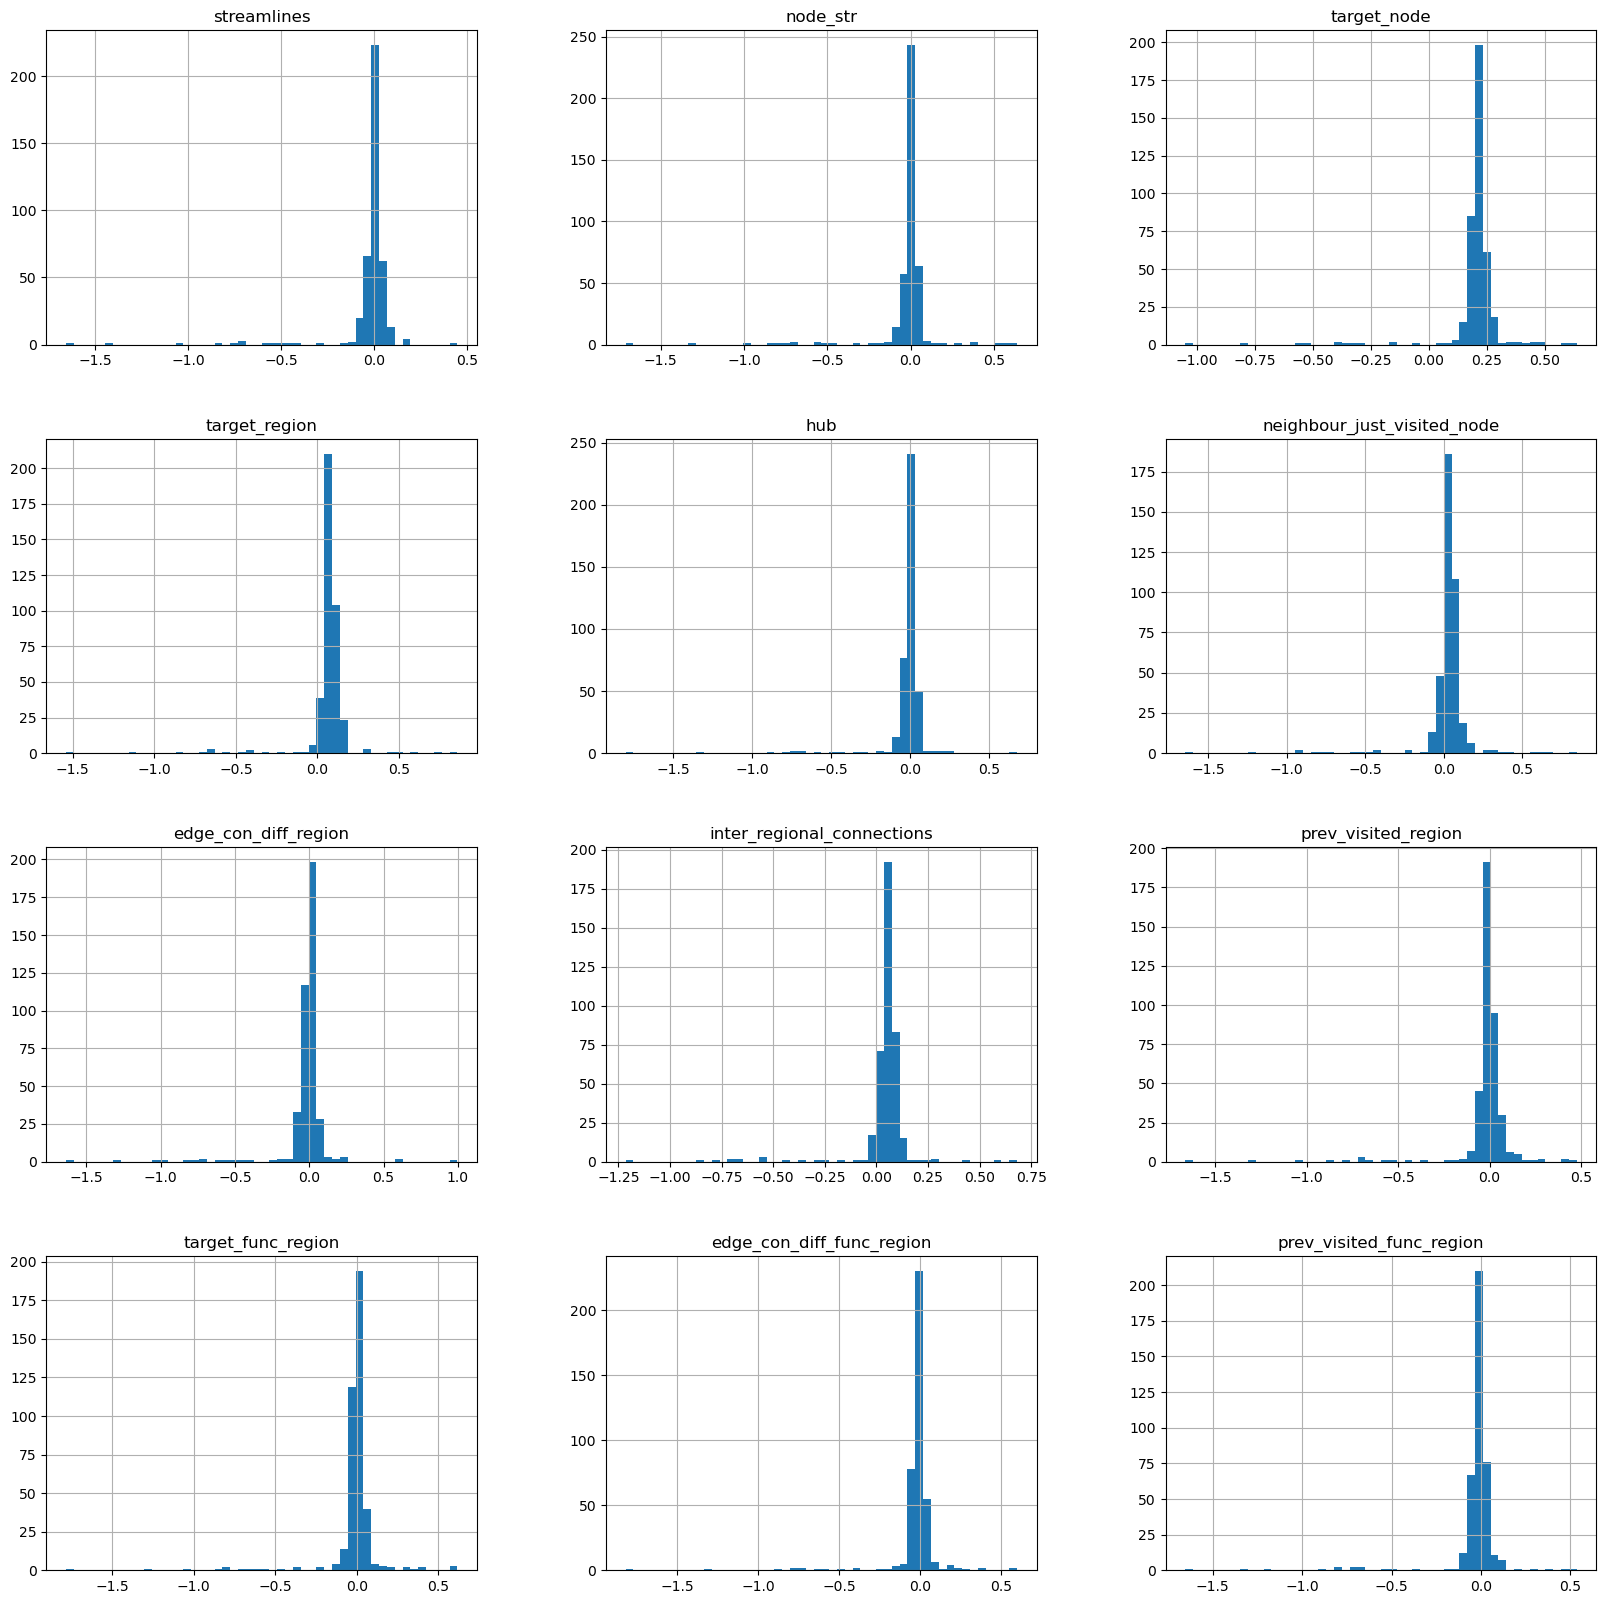

In [15]:
df.T.hist(figsize=(20,20),bins=50);

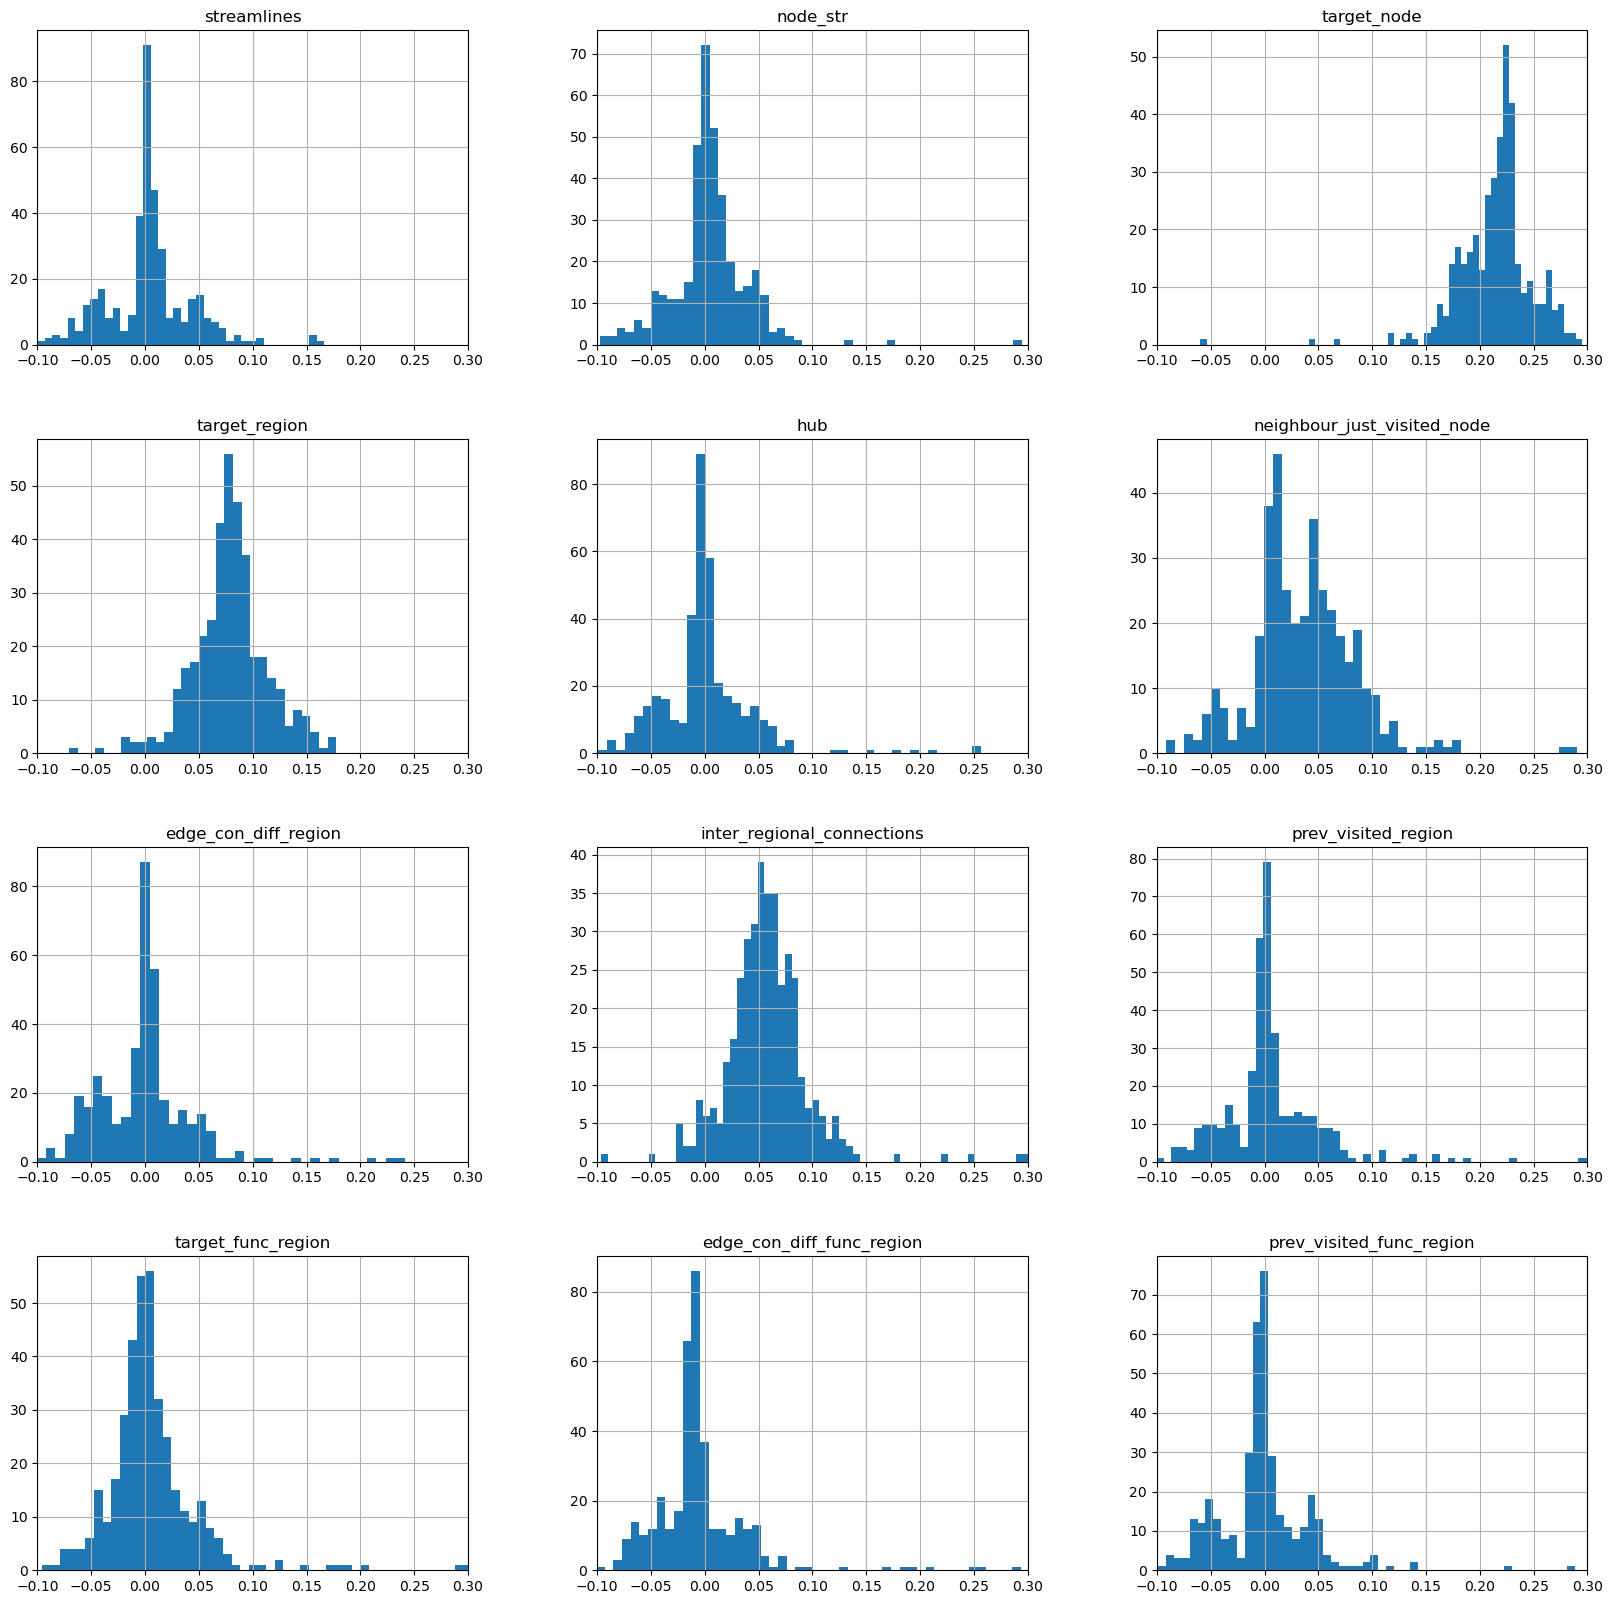

In [20]:
p1 = df.T.hist(figsize=(20,20),bins=300);
for p2 in p1:
    for p in p2:
        p.set_xlim([-0.1,0.3])

In [17]:
df_by_batch = df.stack(level=0)

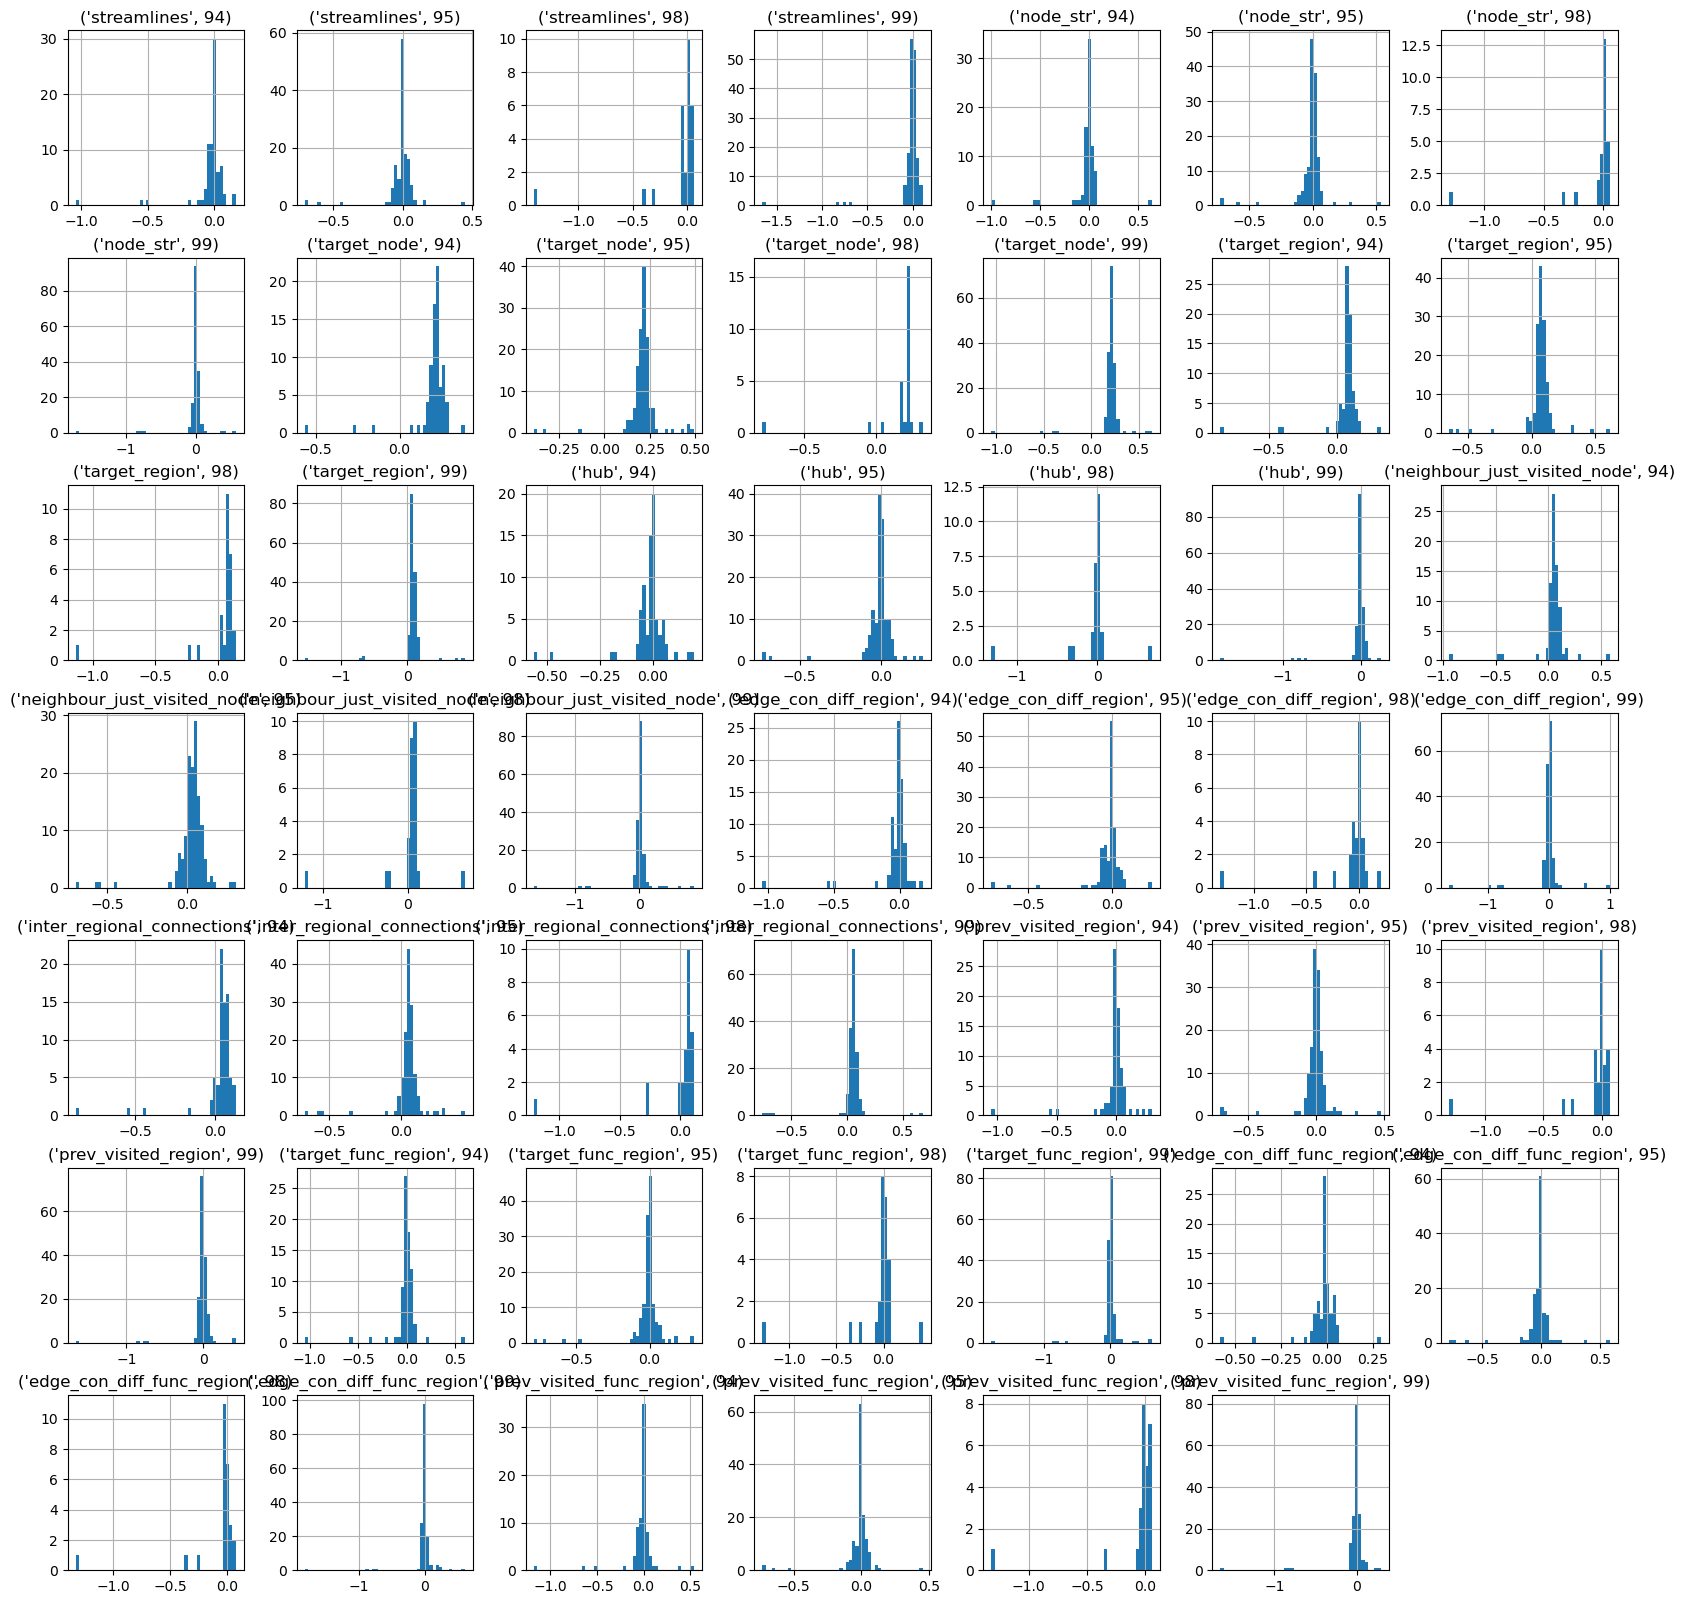

In [19]:
df_by_batch.T.hist(figsize=(20,20),bins=50);

In [22]:
df_by_batch.T.describe().T

count      mean       std       min       25%  \
streamlines                 94   78.0 -0.026456  0.151983 -1.044745 -0.034449   
                            95  139.0 -0.011578  0.118663 -0.708582 -0.014888   
                            98   27.0 -0.076156  0.283721 -1.405979 -0.040324   
                            99  162.0 -0.020805  0.169646 -1.657340 -0.009679   
node_str                    94   78.0 -0.021123  0.163870 -0.997585 -0.026270   
                            95  139.0 -0.014205  0.123261 -0.725989 -0.017744   
                            98   27.0 -0.060746  0.261124 -1.294697 -0.007411   
                            99  162.0 -0.010825  0.184403 -1.710892 -0.007295   
target_node                 94   78.0  0.199439  0.119127 -0.566945  0.198807   
                            95  139.0  0.210440  0.093797 -0.392729  0.194614   
                            98   27.0  0.163482  0.201921 -0.789728  0.185531   
                            99  162.0  0.204522  0.144284 -1.049675  0.194636   
target_region               94   77.0  0.057877  0.138191 -0.853234  0.063636   
                            95  139.0  0.067258  0.124197 -0.642235  0.050339   
                            98   27.0  0.016823  0.243205 -1.135125  0.060496   
                            99  162.0  0.071346  0.187805 -1.542102  0.063944   
hub                         94   77.0 -0.016914  0.099346 -0.563358 -0.039981   
                            95  139.0 -0.018489  0.119595 -0.728584 -0.027205   
                            98   27.0 -0.045440  0.301706 -1.322040 -0.011619   
                            99  162.0 -0.026368  0.180187 -1.802268 -0.014092   
neighbour_just_visited_node 94   77.0  0.042115  0.158917 -0.936636  0.034162   
                            95  139.0  0.037995  0.107797 -0.667765  0.033219   
                            98   27.0  0.016775  0.286657 -1.217372  0.036193   
                            99  162.0  0.016849  0.222505 -1.643581 -0.002744   
edge_con_diff_region        94   77.0 -0.030154  0.150914 -1.041458 -0.039481   
                            95  139.0 -0.023265  0.115618 -0.718304 -0.033159   
                            98   27.0 -0.074832  0.270082 -1.315277 -0.055432   
                            99  162.0 -0.013514  0.206008 -1.637530 -0.033219   
inter_regional_connections  94   77.0  0.024955  0.140936 -0.872172  0.033176   
                            95  139.0  0.044447  0.117412 -0.669496  0.037191   
                            98   26.0 -0.010546  0.263484 -1.215216  0.034646   
                            99  161.0  0.045434  0.140083 -0.760673  0.039416   
prev_visited_region         94   77.0 -0.018511  0.160098 -1.047560 -0.010568   
                            95  139.0 -0.009274  0.126819 -0.706319 -0.021600   
                            98   26.0 -0.073557  0.265478 -1.303135 -0.043858   
                            99  161.0 -0.017876  0.178877 -1.661841 -0.012735   
target_func_region          94   77.0 -0.016401  0.165537 -1.054190 -0.021496   
                            95  139.0 -0.015213  0.124073 -0.790727 -0.019067   
                            98   26.0 -0.048690  0.279154 -1.279655 -0.006600   
                            99  161.0 -0.008158  0.194948 -1.781847 -0.015160   
edge_con_diff_func_region   94   77.0 -0.022287  0.093590 -0.577302 -0.029439   
                            95  139.0 -0.024689  0.133302 -0.779588 -0.041398   
                            98   26.0 -0.077843  0.270629 -1.330060 -0.022506   
                            99  161.0 -0.021663  0.195159 -1.818529 -0.021540   
prev_visited_func_region    94   77.0 -0.024670  0.185944 -1.179011 -0.039906   
                            95  139.0 -0.020112  0.124554 -0.730530 -0.012549   
                            98   26.0 -0.062194  0.267018 -1.317980 -0.016847   
                            99  161.0 -0.027713  0.176912 -1.653931 -0.032846   

                                     50%       75%       max  

/tmp/ipykernel_11088/665509831.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axarr = pd.plotting.scatter_matrix(df.T, ax = plt.gca());


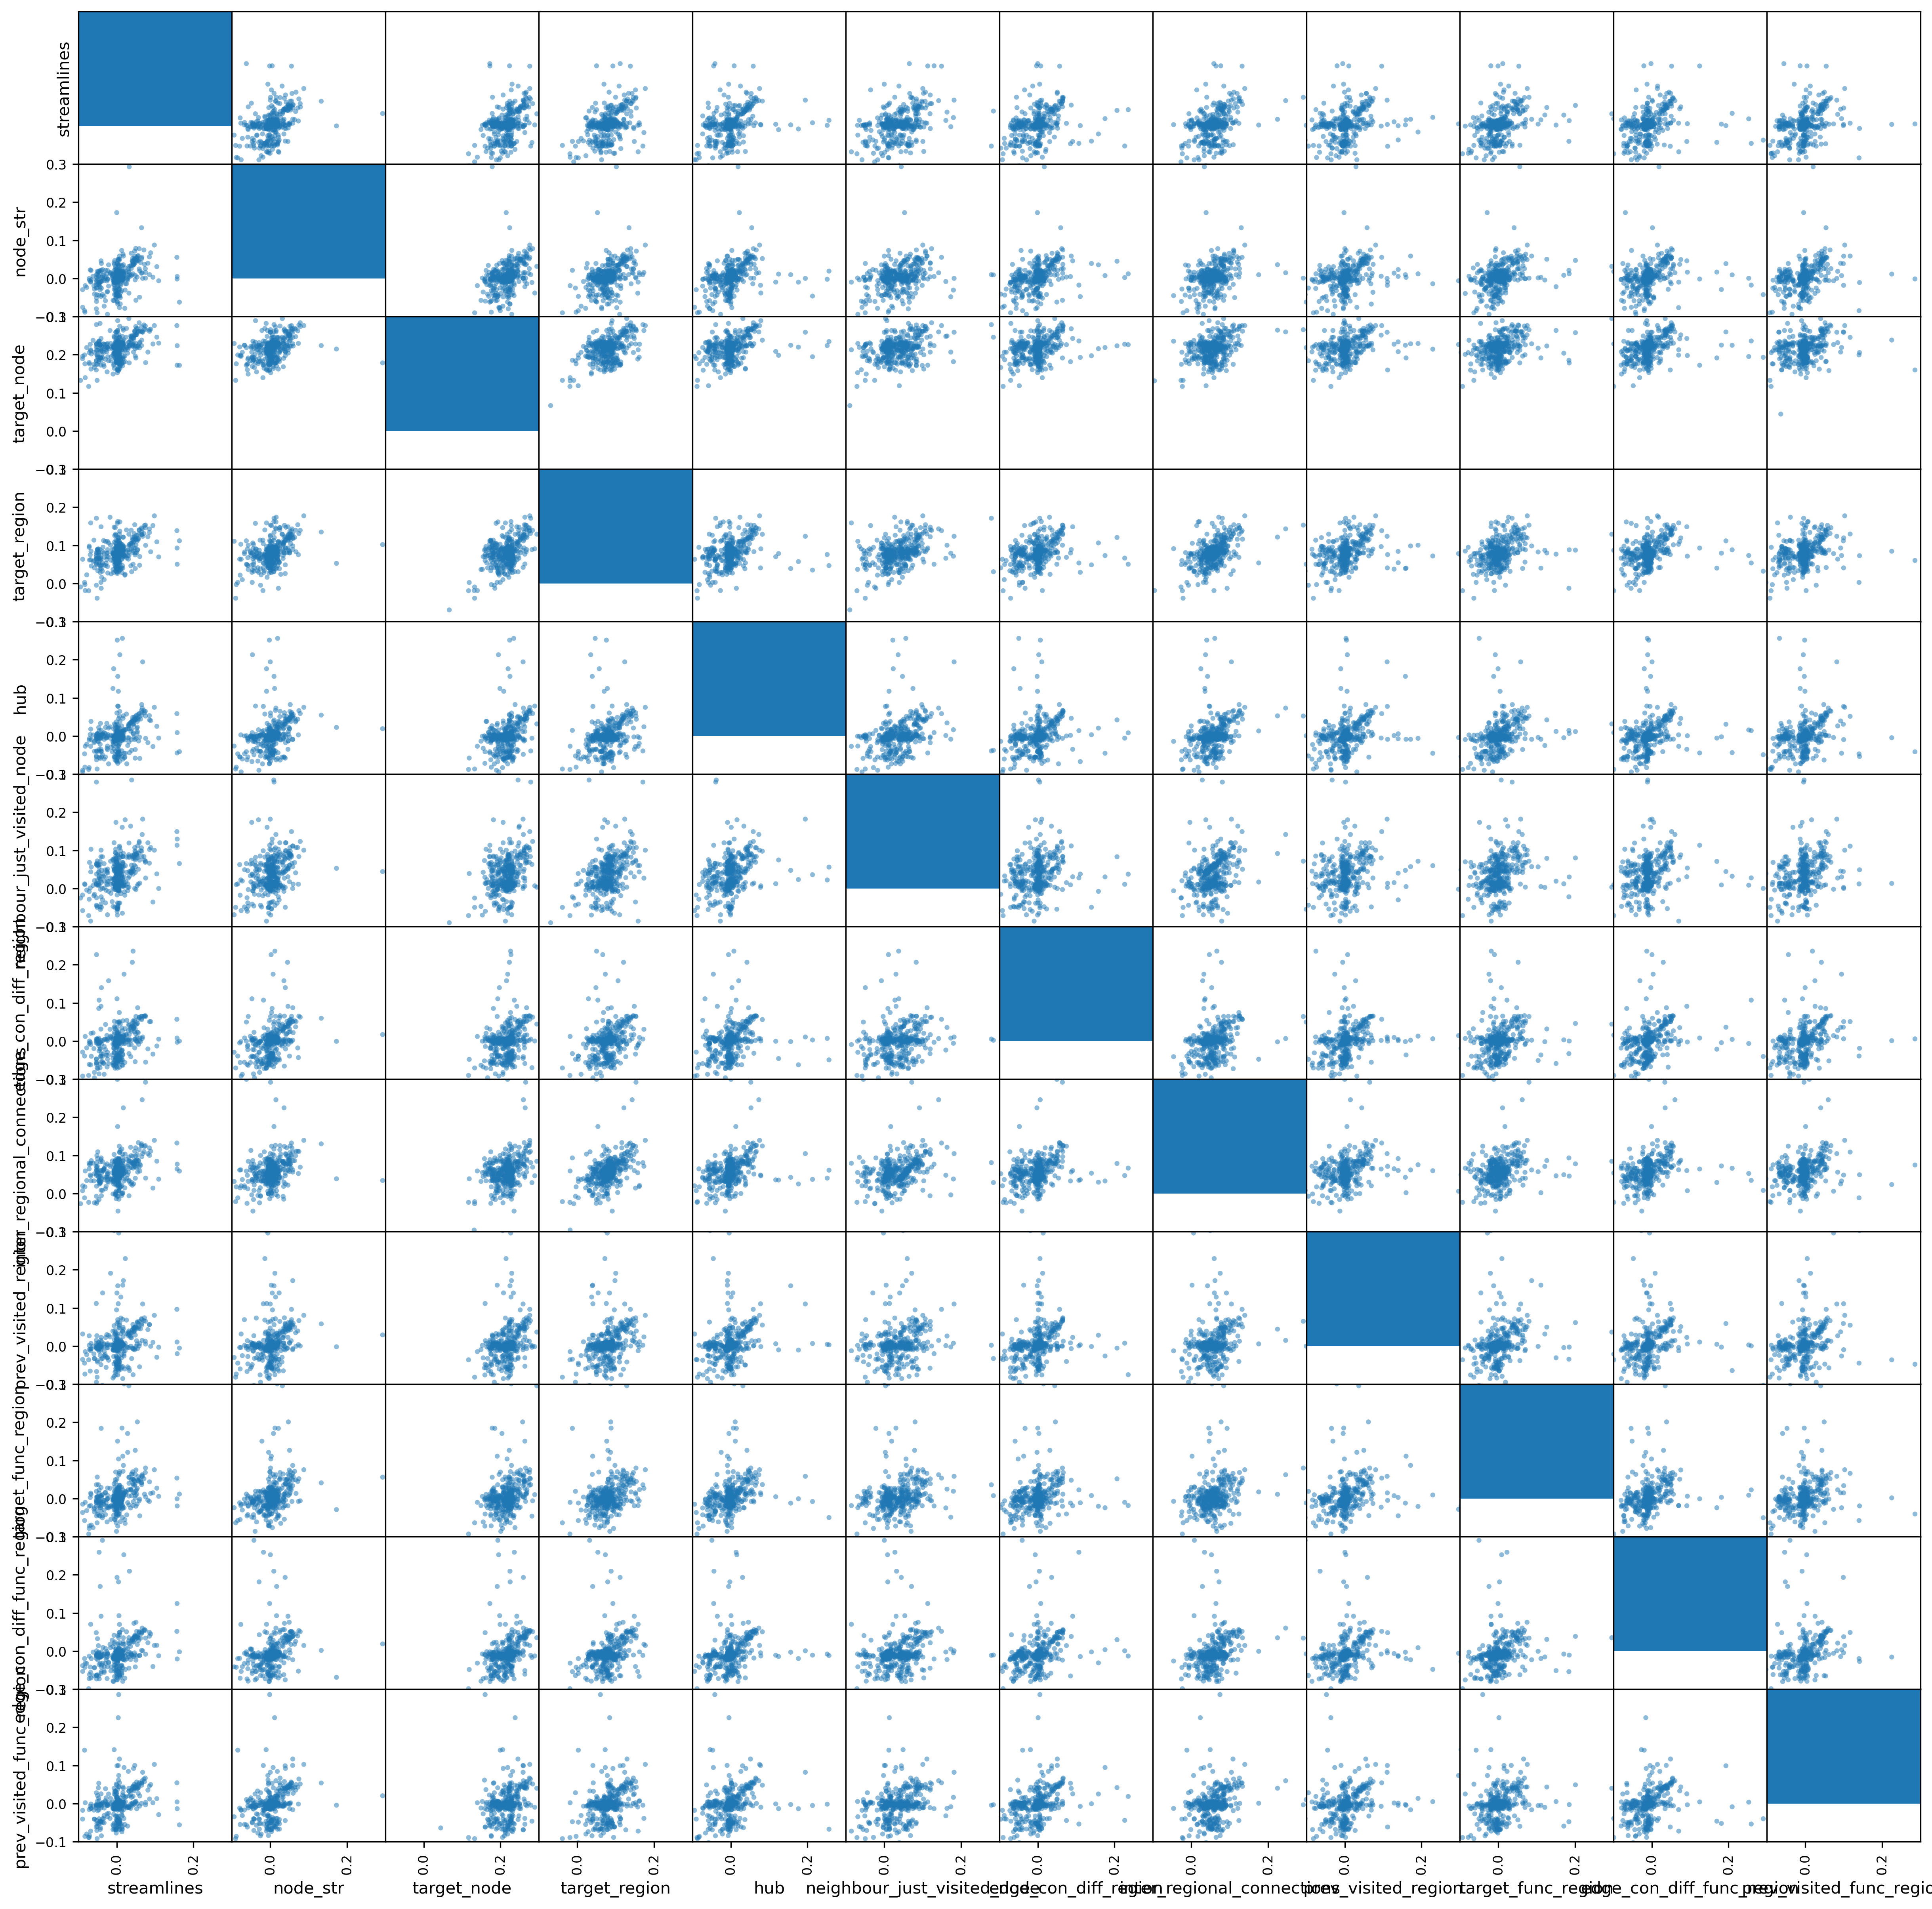

In [22]:
fig = plt.figure(dpi=300, figsize=(20,20))
axarr = pd.plotting.scatter_matrix(df.T, ax = plt.gca());
for i in range(12):
    for j in range(12):
        axarr[i,j].set_xlim(-0.1,0.3)
        axarr[i,j].set_ylim(-0.1,0.3)

In [ ]:
results_brain = process_batch(99)

df = pd.DataFrame({key: {criteria[i-1] : results_brain[key][i] for i in range(1,13)} for key in results_brain})

df.T.hist()

array([[<Axes: title={'center': 'streamlines'}>,
        <Axes: title={'center': 'node_str'}>,
        <Axes: title={'center': 'target_node'}>],
       [<Axes: title={'center': 'target_region'}>,
        <Axes: title={'center': 'hub'}>,
        <Axes: title={'center': 'neighbour_just_visited_node'}>],
       [<Axes: title={'center': 'edge_con_diff_region'}>,
        <Axes: title={'center': 'inter_regional_connections'}>,
        <Axes: title={'center': 'prev_visited_region'}>],
       [<Axes: title={'center': 'target_func_region'}>,
        <Axes: title={'center': 'edge_con_diff_func_region'}>,
        <Axes: title={'center': 'prev_visited_func_region'}>]],
      dtype=object)

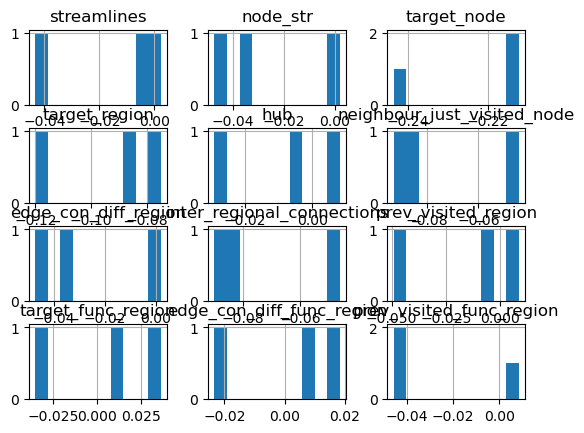

In [91]:
results_02 = compare_brain_by_batch(2)

df = pd.DataFrame({key: {criteria[i-1] : results_02[key][i] for i in range(1,13)} for key in results_02})

df.T.hist()

array([[<Axes: title={'center': 'streamlines'}>,
        <Axes: title={'center': 'node_str'}>,
        <Axes: title={'center': 'target_node'}>],
       [<Axes: title={'center': 'target_region'}>,
        <Axes: title={'center': 'hub'}>,
        <Axes: title={'center': 'neighbour_just_visited_node'}>],
       [<Axes: title={'center': 'edge_con_diff_region'}>,
        <Axes: title={'center': 'inter_regional_connections'}>,
        <Axes: title={'center': 'prev_visited_region'}>],
       [<Axes: title={'center': 'target_func_region'}>,
        <Axes: title={'center': 'edge_con_diff_func_region'}>,
        <Axes: title={'center': 'prev_visited_func_region'}>]],
      dtype=object)

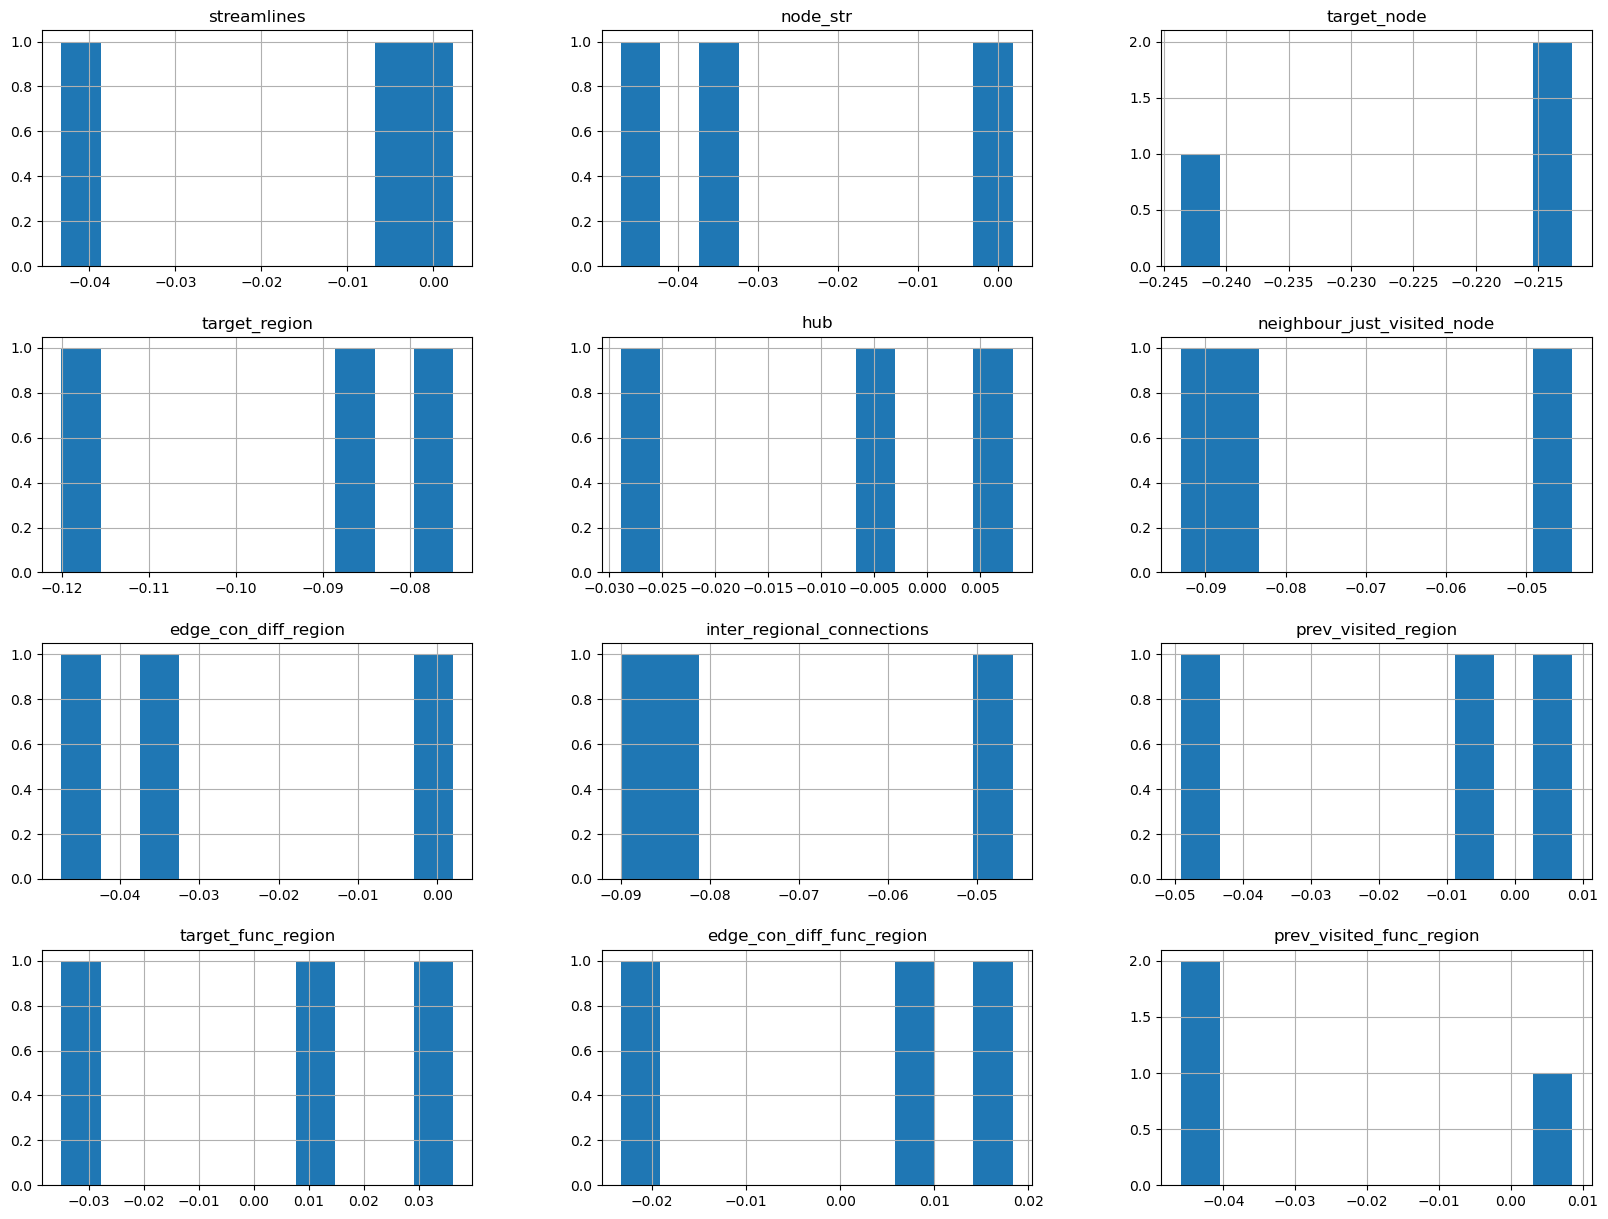

In [97]:
df.T.hist(figsize=(20,15))

In [98]:
os.path.isfile("blah")

False

In [123]:
np.NaN

nan